## <font color='indianred'> Exercise 1: Explore filter parameters </font>

In this exercises you will explore how different parameters affect the filtering process.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))

from utils import download_data
import lfp_functions as lf

**Q 1.1 - Import the data from `data/moving_lfp.pickle` (I should already have this)**

In [2]:
with open('data/moving_lfp.pickle','rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']

print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


**Q 1.2 - Take a few seconds of the data and filter them in different frequency bands, plotting the resulting signal. Fix the central frequency and play with the width of the band. Then, try to change the central frequency of the band.**

As was done in the lecture, I'll use the Butterworth filter, keeping the order fixed at 5.

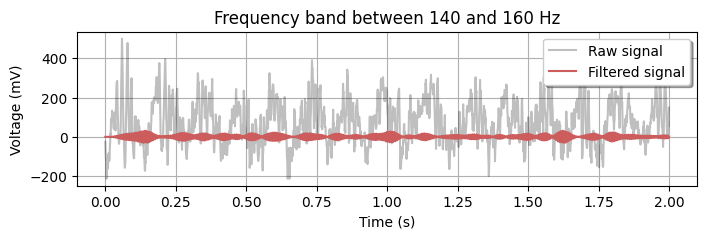

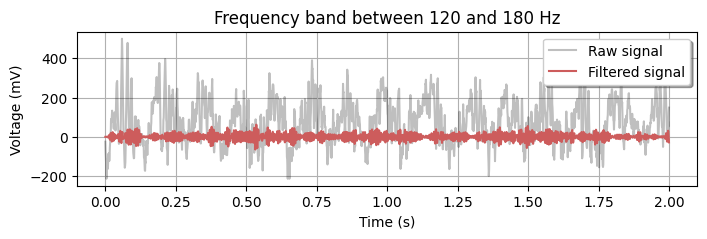

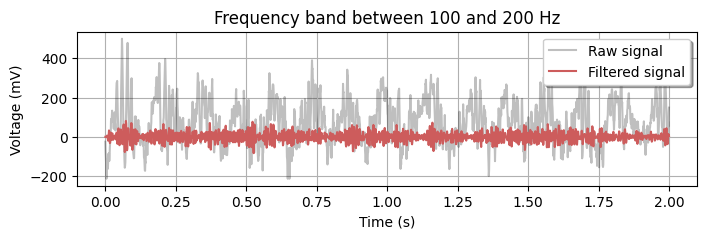

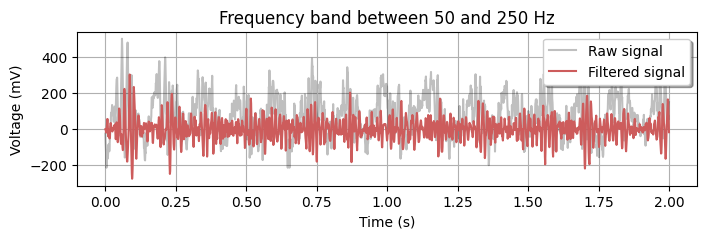

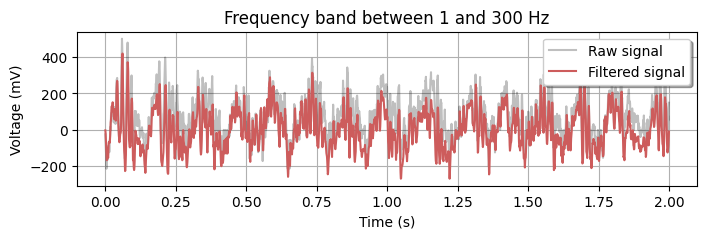

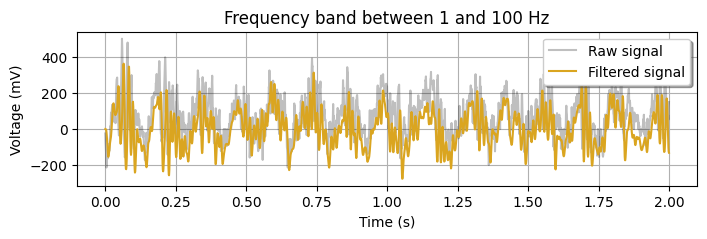

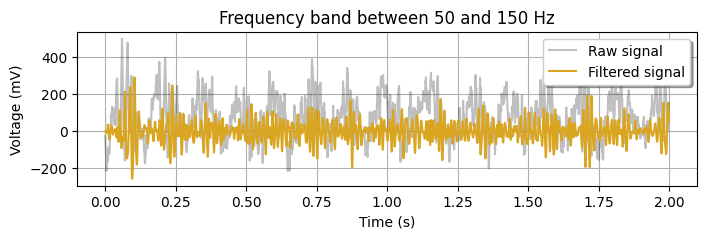

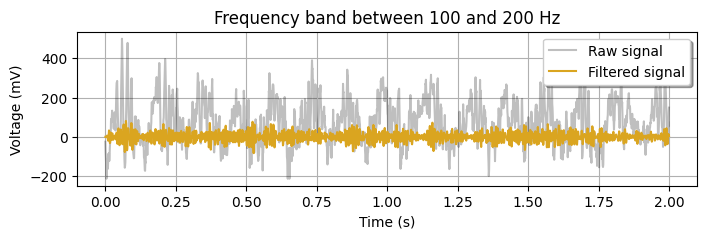

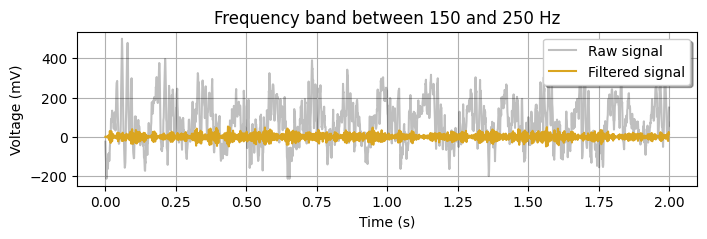

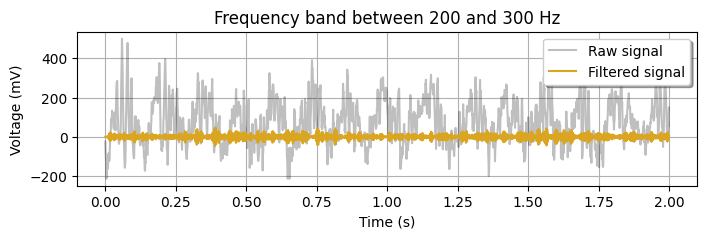

In [3]:
from scipy.signal import butter, sosfilt

filter_order = 5
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)

# Fix central frequency and change width
frequency_bands1 = [[140,160], [120,180],[100,200],[50,250],[1,300]]
for indx in range(len(frequency_bands1)):
    filter = butter(filter_order, frequency_bands1[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='indianred')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands1[indx][0], frequency_bands1[indx][1]))
    plt.show()

# Fix bandwidth and change center of frequency band
frequency_bands2 = [[1,100],[50,150],[100,200],[150,250],[200,300]]
for indx in range(len(frequency_bands2)):
    filter = butter(filter_order, frequency_bands2[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='goldenrod')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands2[indx][0], frequency_bands2[indx][1]))
    plt.show()

**Q 1.3 - Change the order of the filter whilst keeping the frequency band fixed. How does the signal change? How does the computing time change?**

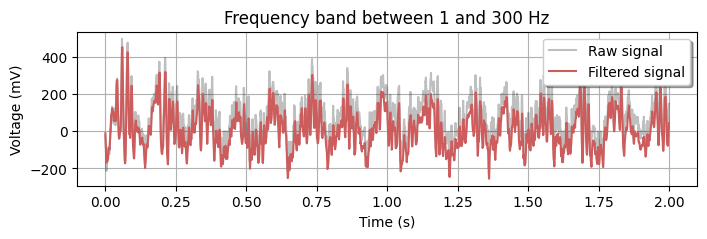

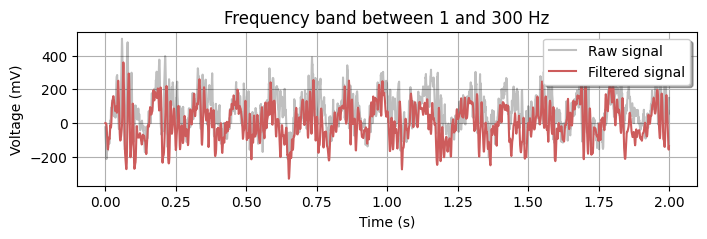

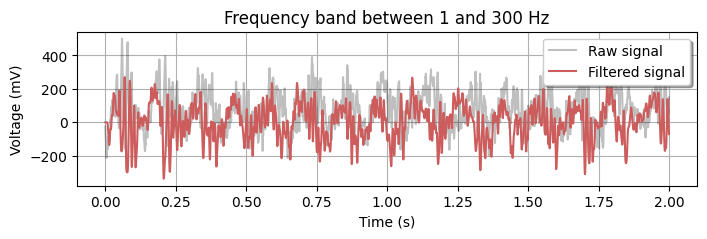

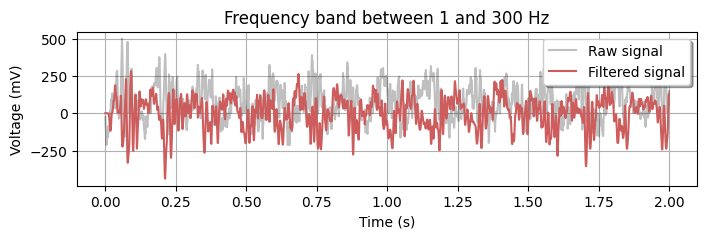

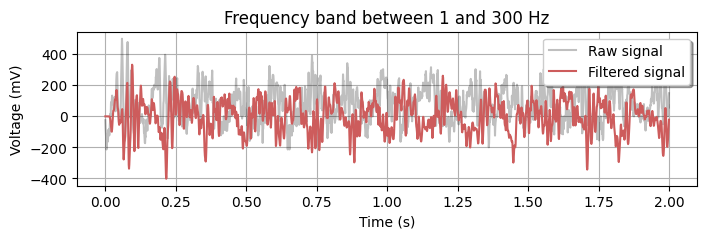

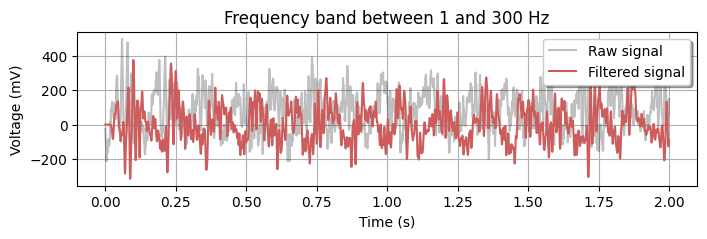

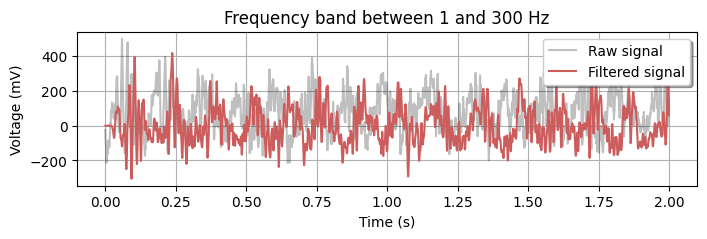

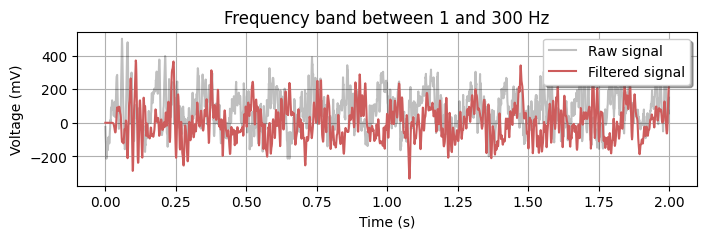

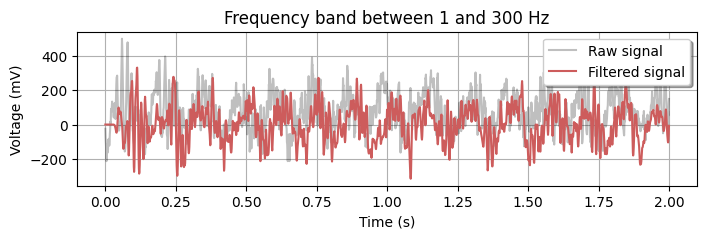

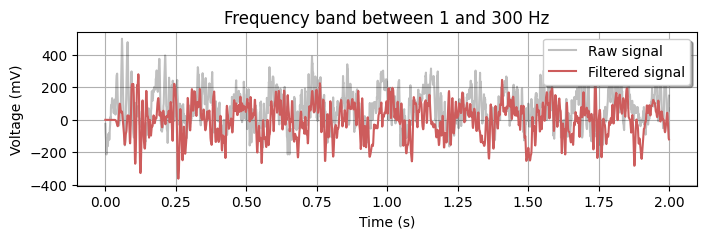

In [4]:
import time

filter_orders = np.arange(1,100,10)
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)
elapsed_times = []

for order in filter_orders:

    start = time.time()
    filter = butter(order, [1,200], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)
    end = time.time()
    elapsed_times.append(end - start)

    # PLOTS  
    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='indianred')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands1[indx][0], frequency_bands1[indx][1]))
    plt.show()

Text(0, 0.5, 'Computation time')

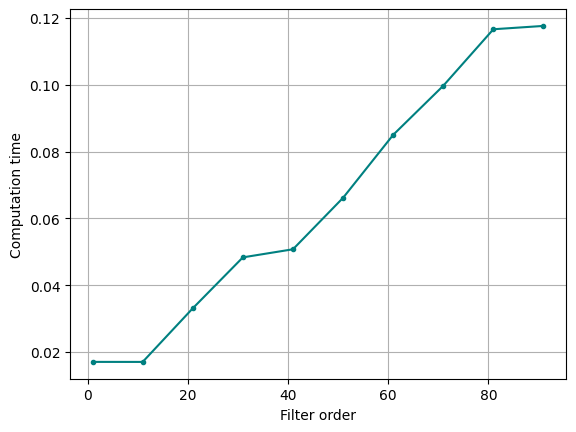

In [5]:
# PLOT ELAPSED TIMES WITH INCREASING FILTER_ORDER
plt.plot(filter_orders, elapsed_times, '.-', color='teal')
plt.grid()
plt.xlabel('Filter order')
plt.ylabel('Computation time')

## <font color='indianred'> Exercise 2: Wavelet transform with real wavelets </font>

In this exercise, you will explore the difference between real and complex wavelets in the CWT.

**Q 2.1 - Select a period of a few seconds of the signal and compute the spectrogram. Try the wavelet transform with `mexh`, `gaus` and `morl`. These are real wavelets.**

*Note to self: A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies in time!*

In [19]:
import pywt
print(pywt.wavelist('mexh'))
print(pywt.wavelist('gaus'))
print(pywt.wavelist('morl'))

['mexh']
['gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8']
['morl']


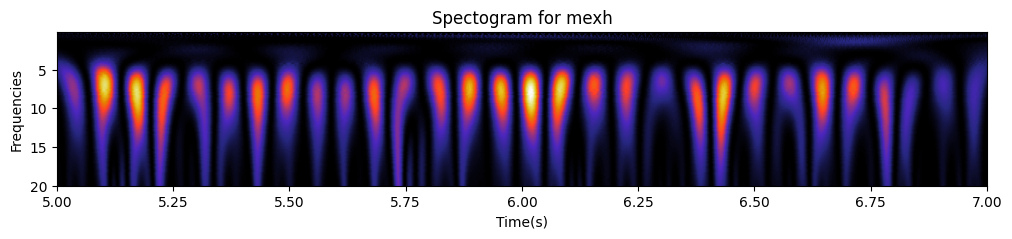

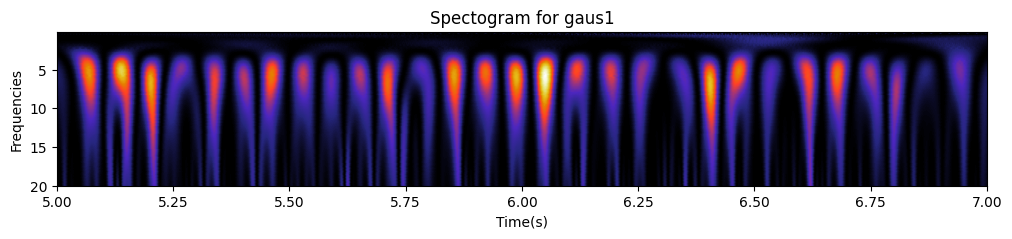

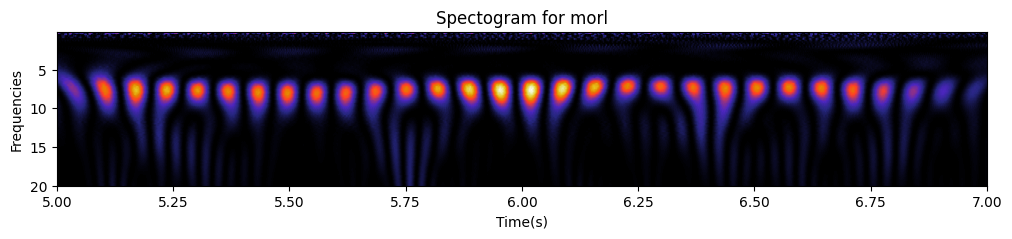

NameError: name 'cwtmatr' is not defined

In [22]:
start, finish = 5,7

# int(s * Hz) = int(s * 1/s) = int(index)
signal = lfp[int(start * sampling_rate) : int(finish * sampling_rate)]

# Detrending
signal -= np.mean(signal) 

# Spectrograms 
wavelets = ['mexh', 'gaus1', 'morl']
frequencies = np.linspace(0.1, 20, 100) / sampling_rate

for wavelet in wavelets:
    scales = pywt.scale2frequency(wavelet, scale = frequencies)
    cwt_matrix, _ = pywt.cwt(signal, wavelet = wavelet, scales = scales)
    plt.figure(figsize=(12,2))
    
    plt.imshow(abs(cwt_matrix)**2, aspect='auto', cmap='CMRmap', extent=[start, finish, frequencies[-1] * sampling_rate,
                                    frequencies[0] * sampling_rate])
    plt.title('Spectogram for {}'.format(wavelet))
    plt.xlabel('Time(s)')
    plt.ylabel('Frequencies')
    plt.show()

**Q 2.2 - What differences do you see with respect to the spectrum computed with the complex Morlet transform? Comment on where do you think are the reason for the differences (or not).**

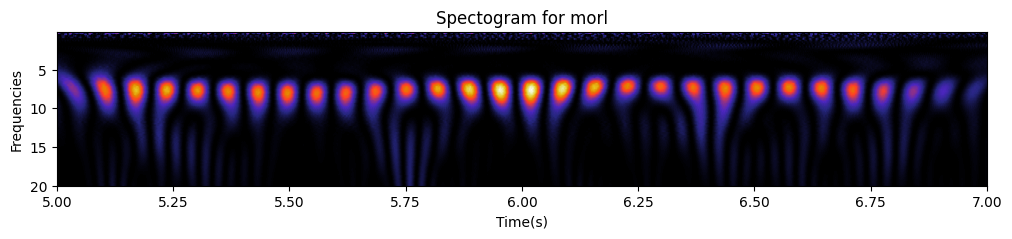

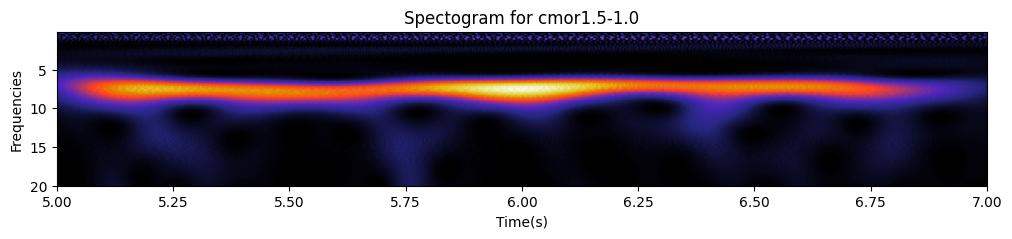

Text(0, 0.5, 'Power')

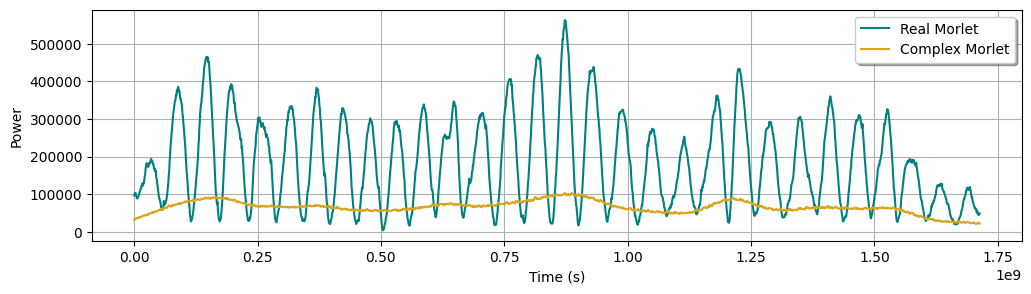

In [24]:
question2_wavelets = ['morl', 'cmor1.5-1.0']
cwt_mats = []
for wavelet in question2_wavelets:
    scales = pywt.scale2frequency(wavelet, scale = frequencies)
    cwt_matrix, _ = pywt.cwt(signal, wavelet = wavelet, scales = scales)
    cwt_mats.append(cwt_matrix)
    plt.figure(figsize=(12,2))
    
    plt.imshow(abs(cwt_matrix)**2, aspect='auto', cmap='CMRmap', extent=[start, finish, frequencies[-1] * sampling_rate,
                                    frequencies[0] * sampling_rate])
    plt.title('Spectogram for {}'.format(wavelet))
    plt.xlabel('Time(s)')
    plt.ylabel('Frequencies')
    plt.show()


power_real_morlet = np.mean(abs(cwt_mats[0])**2, axis = 0)
power_complex_morlet = np.mean(abs(cwt_mats[1])**2, axis = 0)

plt.figure(figsize=(12,3))
plt.plot(np.linspace(start,end, len(power_real_morlet)), power_real_morlet, color='teal', label ='Real Morlet')
plt.plot(np.linspace(start,end, len(power_complex_morlet)), power_complex_morlet, color='goldenrod', label ='Complex Morlet')
plt.grid()
plt.legend(shadow=True)
plt.xlabel('Time (s)')
plt.ylabel('Power')